# Convolutional Neural Net with Word Embeddings
Adapted from code at https://github.com/fchollet/keras/blob/master/examples/imdb_cnn.py

This example demonstrates the use of Convolution1D for text classification.
Gets to 0.89 test accuracy after 2 epochs.
90s/epoch on Intel i5 2.4Ghz CPU.
10s/epoch on Tesla K40 GPU.

# CNN
Convolutions are sliding window functions applied to a matrix that achieve specific results (e. g., image blur, edge detection.) The sliding window is called a kernel, filter, or feature detector. The visualization shows six 3×3 kernels that multiply their values element-wise with the original matrix, then sum them up. To get the full convolution, we do this for each element by sliding the filter over the entire matrix:

![CNN](https://thumbs.gfycat.com/PlasticMenacingDegu-size_restricted.gif) 

## Import modules

In [1]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

Using TensorFlow backend.


### Set parameters

In [2]:
max_words = 5000 # vocabulary size
maxlen = 80      # max sentense length
batch_size = 32
embedding_dims = 50
filters = 100    # the number of output filters in the convolution
kernel_size = 3  # length of the 1D convolution window
hidden_dims = 250
epochs = 3

## Loading data

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

25000 train sequences
25000 test sequences


### Pad sequences
Pad sequences to (samples x length)

In [4]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (25000, 80)
x_test shape: (25000, 80)


Show one sentence

In [5]:
x_train[0]

array([  15,  256,    4,    2,    7, 3766,    5,  723,   36,   71,   43,
        530,  476,   26,  400,  317,   46,    7,    4,    2, 1029,   13,
        104,   88,    4,  381,   15,  297,   98,   32, 2071,   56,   26,
        141,    6,  194,    2,   18,    4,  226,   22,   21,  134,  476,
         26,  480,    5,  144,   30,    2,   18,   51,   36,   28,  224,
         92,   25,  104,    4,  226,   65,   16,   38, 1334,   88,   12,
         16,  283,    5,   16, 4472,  113,  103,   32,   15,   16,    2,
         19,  178,   32], dtype=int32)

## Defining the network

In [6]:
model = Sequential()

We start off with an efficient embedding layer which maps
our vocab indices into embedding_dims dimensions

In [7]:
model.add(Embedding(max_words,
                    embedding_dims,
                    input_length=maxlen))

model.add(Dropout(0.2))

We add a `Convolution1D`, which will learn word group filters of size `kernel_size`:

In [8]:
model.add(Conv1D(filters,           # output size
                 kernel_size,       # width of convolution window
                 padding='valid',   # "valid" means "no padding"
                 activation='relu', # Rectified Linear Unit
                 strides=1))        # consecutive, no gaps

We use max pooling:

In [9]:
model.add(GlobalMaxPooling1D())

We add a vanilla hidden layer:

In [10]:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

We project onto a single unit output layer, and squash it with a sigmoid:

In [11]:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Show the model

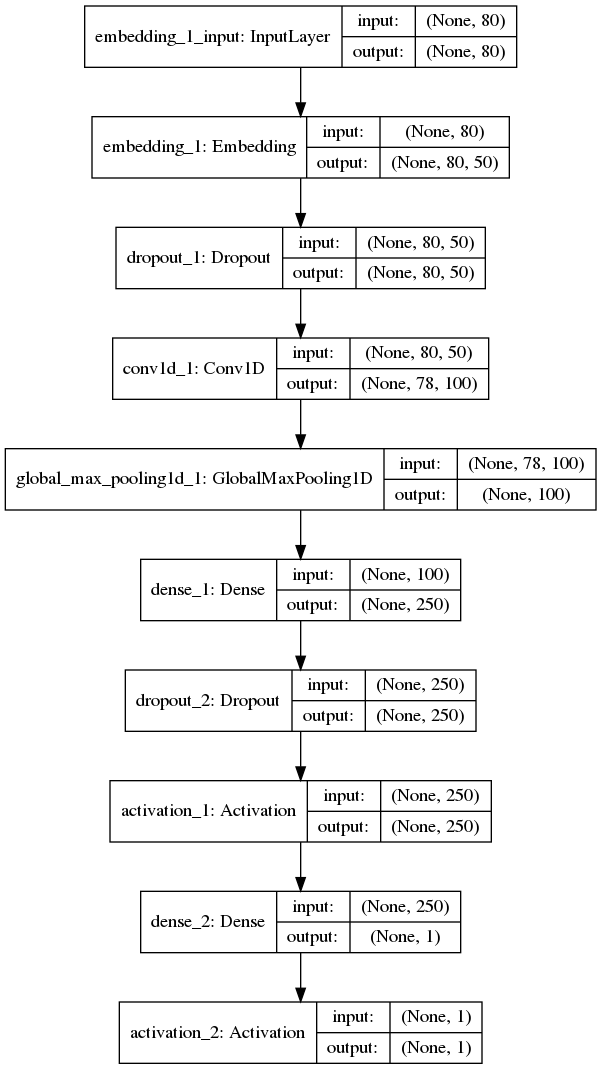

In [12]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

## Training
Save a random 10% of thre training set for validation.

In [13]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 22500 samples, validate on 2500 samples
Epoch 1/3
22500/22500 [==============================] - 19s 830us/step - loss: 0.4845 - accuracy: 0.7494 - val_loss: 0.3639 - val_accuracy: 0.8316
Epoch 2/3
22500/22500 [==============================] - 18s 812us/step - loss: 0.3068 - accuracy: 0.8674 - val_loss: 0.3420 - val_accuracy: 0.8512
Epoch 3/3
22500/22500 [==============================] - 18s 811us/step - loss: 0.2247 - accuracy: 0.9103 - val_loss: 0.3731 - val_accuracy: 0.8420


## Testing
Let's see how well the model performs on the test set.

In [14]:
predictions = model.predict(x_test)

In [15]:
predictions

array([[0.06467261],
       [0.89036936],
       [0.93738186],
       ...,
       [0.36623505],
       [0.03460545],
       [0.756571  ]], dtype=float32)

In [16]:
predictions.round()

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]], dtype=float32)

In [17]:
y_test

array([0, 1, 1, ..., 0, 0, 0])

In [18]:
import numpy as np
errors = y_test-predictions.round().flatten()
errors

array([ 0.,  0.,  0., ...,  0.,  0., -1.])

In [19]:
len(errors[errors==0])

20819

In [20]:
len(errors[errors==0])/len(errors)

0.83276

## Evaluate the results

In [21]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8328


## Exploring the embeddings

In [22]:
model.layers

In [23]:
embeddings = model.get_weights()[0]
embeddings.shape

(5000, 50)

In [24]:
embeddings[0]

array([-0.01447591,  0.08588997,  0.00091831,  0.0496854 , -0.06784604,
        0.03779935,  0.0362602 , -0.0177965 ,  0.01330217,  0.02572451,
        0.00570524,  0.05210804, -0.00956483, -0.03514406, -0.05008016,
        0.05200245, -0.03379247,  0.02226655,  0.01908852,  0.0658993 ,
        0.0559688 ,  0.02636949,  0.0550785 , -0.03949598,  0.02514827,
       -0.01164682, -0.06460676, -0.03809603, -0.04677157, -0.03670121,
        0.03958731,  0.06059533,  0.07646205, -0.01401159,  0.00266467,
        0.11357006, -0.05006231,  0.0082712 , -0.0820943 , -0.00877421,
        0.08628178,  0.03094251,  0.01087565,  0.05626277, -0.05357581,
       -0.07181673, -0.02064846, -0.05353614,  0.0478964 ,  0.01131588],
      dtype=float32)

In [25]:
embeddings[2].dot(embeddings[4])

0.06054212

## Comparison with one-hot representations

In [26]:
model_one_hot = Sequential()

This is NOT a real embedding layer, it is just a trick 
to convert words into one-hot representations.

Note that the embeddinfs are not trained, thet never changes during training.

In [27]:
model_one_hot.add(Embedding(max_words,
                    max_words,
                    embeddings_initializer='identity',
                    input_length=maxlen,
                    trainable=False))  # do not train the embeddings

model_one_hot.add(Dropout(0.2))

We add a `Convolution1D`, which will learns word group filters of size kernel_size:

In [28]:
model_one_hot.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))

We use max pooling:

In [29]:
model_one_hot.add(GlobalMaxPooling1D())

We add a vanilla hidden layer:

In [30]:
model_one_hot.add(Dense(hidden_dims))
model_one_hot.add(Dropout(0.2))
model_one_hot.add(Activation('relu'))

We project onto a single unit output layer, and squash it with a sigmoid:

In [31]:
model_one_hot.add(Dense(1))
model_one_hot.add(Activation('sigmoid'))

Compile the model:

In [32]:
model_one_hot.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

### Show model

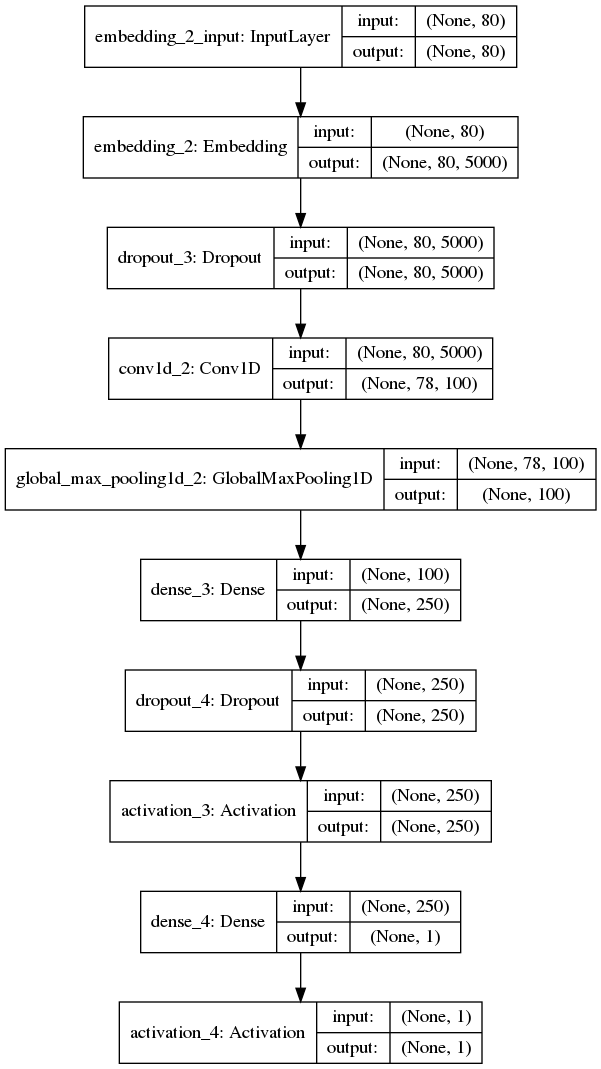

In [33]:
plot_model(model_one_hot, show_shapes=True)

### Train the model

In [ ]:
history = model_one_hot.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/3
10976/22500 [=============>................] - ETA: 4:51 - loss: 0.5875 - accuracy: 0.6638

In [53]:
one_hot = model_one_hot.get_weights()[0]
one_hot.shape

(5000, 5000)

In [54]:
one_hot[0]

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

## Evaluate the results

In [55]:
loss, accuracy = model_one_hot.evaluate(x_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8485
